# **Image Sementation**

# We want to implement a model to learn the segmentation map for some pets images. [link](https://www.robots.ox.ac.uk/~vgg/data/pets/)
> ## **Dataset: The Oxford-IIIT Pet Dataset**
> ### We are given 7390 images.
*   #### There are 37 categories of pets  with roughly 200 images for each class
*   #### The images have a large variations in scale, pose and lighting.
*   #### All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation (**Trimap**)
*   #### We will be using the trimap, containg only three pixel values, 1, 2 or 3, one for each of:
    * a **definite foreground**
    * a **definite background**,
    * a **blended region**, where pixels are considered as a mixture of foreground and background colors  

> ## This task to classify each pixel on the image as either 1, 2 or 3.

> ## The image are be 3D RGB (3 input channels), whereas trimaps mask are 2D, 1 channel.


<hr>

In [3]:
import numpy as np
import os

import matplotlib.pyplot as plt

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
%ls

gdrive/  sample_data/


In [6]:
%rm annotations.tar.gz


rm: cannot remove 'annotations.tar.gz': No such file or directory


In [7]:

## Get a webpage and store in a local file, make the local file get the name of the
##  remote document (if no filename part is specified in the URL, this fails):
#!curl -O https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
#!curl -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz  -P . --no-check-certificate
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz  -P . --no-check-certificate

--2025-04-25 15:47:23--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2025-04-25 15:47:24--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-04-25 15:47:24--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

In [8]:
!tar -xzvf images.tar.gz
!tar -xzvf annotations.tar.gz

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

In [9]:
%ls

annotations/  annotations.tar.gz  gdrive/  images/  images.tar.gz  sample_data/


In [10]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (128, 128)
num_classes = 3 # the three pixels in the trimap mask


## **Setting paths for images and their trimap masks**


In [11]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


# **Checking how does one input image and corresponding segmentation mask look like**
> ## Apparently trimaps are black, but it is not black. It has pixels as classes, 1, 2, 3
> ## By increasing the contrast we can see them

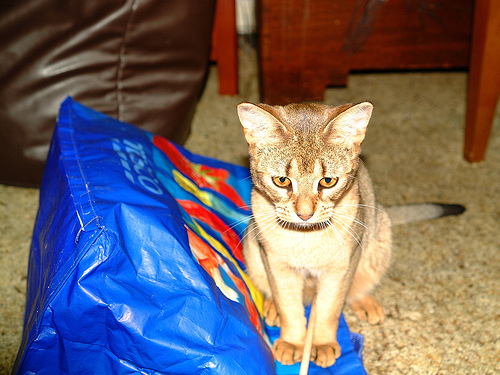

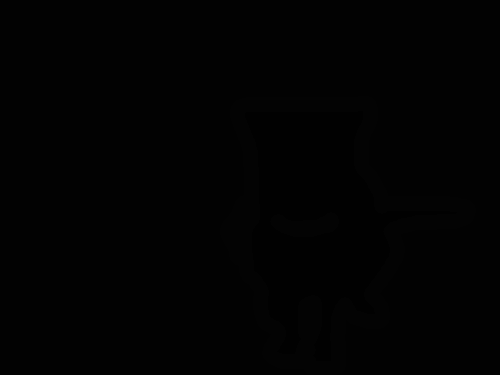

width, height: (500, 375)
min pixel:1, max pixel:3


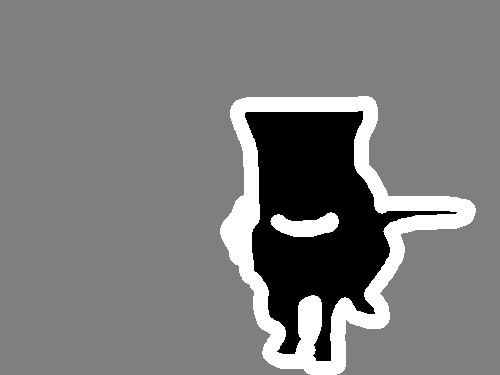

In [12]:
from IPython.display import Image, display
from PIL import Image as Im
from keras.utils import load_img
from PIL import ImageOps

img_id = 7
# Display input image #7
display(Image(filename=input_img_paths[img_id]))

# Display corresponding mask (segmented image)
# We see a black image but it is not black. It has pixels as classes, 0,1, 2, ..
display(Image(filename=target_img_paths[img_id]))
## checking pixel values

im = Im.open(target_img_paths[img_id], 'r')
width, height = im.size
print(f"width, height: {width, height}")
pixel_values = list(im.getdata())
print(f"min pixel:{np.min(pixel_values)}, max pixel:{np.max(pixel_values)}")
# Display auto-contrast version of corresponding target (per-pixel categories)
#   Scale the image setting the highest pixle value to correspond 255
img = ImageOps.autocontrast(load_img(target_img_paths[img_id]))
display(img)

## Prepare dataset to load and vectorize batches of data
> * ### Trimaps labels are translated to 0, 1, 2

In [13]:
import keras
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

# **Buildng training and testing data**
*   ## Set aside a test split

In [14]:
import random
seed = 123
# Split our img paths into a train and a test sets
test_samples = 2000
train_samples = 4500
batch_size = 64
random.Random(seed).shuffle(input_img_paths)
random.Random(seed).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:train_samples]
train_target_img_paths = target_img_paths[:train_samples]
val_input_img_paths = input_img_paths[train_samples:(len(input_img_paths)-test_samples)]
val_target_img_paths = target_img_paths[train_samples:(len(input_img_paths)-test_samples)]
test_input_img_paths = input_img_paths[(len(input_img_paths)-test_samples):]
test_target_img_paths = target_img_paths[(len(input_img_paths)-test_samples):]
print(f"number of validation samples:{len(val_input_img_paths)}")
print(f"number of test samples:{len(test_input_img_paths)}")
print(f"number of train samples:{len(train_input_img_paths)}")

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
  # max_dataset_len=1000,
)
val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
test_dataset = get_dataset(
    batch_size, img_size, test_input_img_paths, test_target_img_paths
)

number of validation samples:890
number of test samples:2000
number of train samples:4500


# **Defining the Model Architecture**
* ## Conv2DTranspose operates the transposed convolution to upsample feature maps

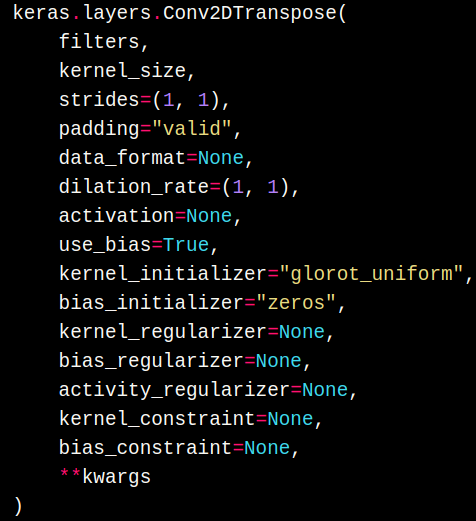

> * ## We will use the U-Net architecture.
>> * ### The transposed convolution is performed by Conv2DTranspose layer [docs](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/)
>> * ### Pay attention to the argument **stride**: it has a different meaning here
>>> * #### it is the "imaginary" stride to be appied to the output to get a feature map of the same size of the input
>>> * #### in practice it performs the upsampling
>>> * #### `stride = (2,2)` with `kernel_size = 2` is doubling the size
>> * ### We can manually upsample and the apply standard convolution to fill/detail the  upsampled cells (Transposed Convolution does both in one!)
>> * ### Keras offers the layer  `UpSampling2d` layer [docs](https://keras.io/api/layers/reshaping_layers/up_sampling2d/)
>>> * #### the argument `size` controls the upsampling rate, whereas argument `interpolation`  controls the way  of filling upsampled cells. Values for `interpolation` are "bicubic", "bilinear", "lanczos3", "lanczos5", "nearest"  





> * ## Take note that the images are normalized inside the model using a lamda layer.

> * ## We use a sofmax output with 3 channels for the pixel-wise multiclass classification into 1,2,3 classes.
use same padding in the last convolutional layer

> * ## Cross Entropy as loss function.
>* ## We will train the network using the images as the input and the masks as the target.

> * ## When Predict is run, the model will output a 3D mask, one map per class.
> * Each pixel in the predicted mask has a vector that represents the probability that that pixel is one of the three classes.
  * ### We need to pick the position with the highset probability via the argmax function

In [15]:
from keras.models import Model, load_model
from keras.layers import Input, Lambda, Dropout, Conv2D, Conv2DTranspose, BatchNormalization
from keras.layers import MaxPooling2D, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# **Due to lack of resources, we pick a small model**

In [16]:

filters = [4, 6, 8, 10, 12]
i = 0
## add a third dimension of value 3. We have RGB images
inputs = Input(shape=img_size + (3,))
#s = Rescaling(1./255)(inputs),
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (s)
# c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)
i+=1
c2 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)
i += 1
c3 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)
i += 1
c4 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
i += 1
c5 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (c5)
i -= 1
### HERE ENDS ENCODER
u6 = Conv2DTranspose(filters[i], (2, 2), strides=(2,2),  padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (c6)
i -= 1
u7 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (c7)
i -= 1
u8 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (c8)
i -= 1
u9 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(filters[i], (3, 3), activation='relu', kernel_initializer='he_normal',
            padding='same') (c9)

# Add a per-pixel classification layer
outputs = Conv2D(num_classes, 3, padding='same', activation='softmax', )(c9)

model = Model(inputs=[inputs], outputs=[outputs])
lr = 0.001
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy (because our
#   target data is integers) for multiclass classification.
#  Now the softmax in in depth, each pixel then will undergo to
#   argmax for getting the class
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
          loss="sparse_categorical_crossentropy"
)

filepath = "model.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                             save_best_only=True, mode='min')

callbacks_list = [checkpoint]


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        112 │ lambda[0][0]      │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        148 │ dropout[0][0]     │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64, 4) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64, 6) │        222 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64, 6) │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64, 6) │        330 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32, 6) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32, 8) │        440 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32, 8) │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32, 8) │        584 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16, 8) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │        730 │ max_pooling2d_2[… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │        910 │ dropout_3[0][0]   │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 10)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 12)  │      1,092 │ max_pooling2d_3[

 Total params: 12,991 (50.75 KB)

 Trainable params: 12,991 (50.75 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

## Using validation set during training to estimate the loss. I haven't specified a metric



In [17]:
#filepath = "model.h5"



#earlystopper = EarlyStopping(patience=5, verbose=1)

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
#                             save_best_only=True, mode='min')

#callbacks_list = [checkpoint]

epochs = 50
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks_list,
    verbose=2,
)

Epoch 1/50


71/71 - 45s - 634ms/step - loss: 0.9636 - val_loss: 0.9023
Epoch 2/50


71/71 - 13s - 184ms/step - loss: 0.8297 - val_loss: 0.7925
Epoch 3/50


71/71 - 22s - 311ms/step - loss: 0.7763 - val_loss: 0.7701
Epoch 4/50


71/71 - 20s - 276ms/step - loss: 0.7462 - val_loss: 0.7352
Epoch 5/50


71/71 - 13s - 184ms/step - loss: 0.6987 - val_loss: 0.7033
Epoch 6/50
71/71 - 15s - 215ms/step - loss: 0.6830 - val_loss: 0.7034
Epoch 7/50


71/71 - 20s - 280ms/step - loss: 0.6705 - val_loss: 0.6951
Epoch 8/50


71/71 - 20s - 275ms/step - loss: 0.6594 - val_loss: 0.6779
Epoch 9/50


71/71 - 14s - 194ms/step - loss: 0.6510 - val_loss: 0.6636
Epoch 10/50


71/71 - 20s - 281ms/step - loss: 0.6430 - val_loss: 0.6483
Epoch 11/50


71/71 - 21s - 298ms/step - loss: 0.6353 - val_loss: 0.6405
Epoch 12/50
71/71 - 20s - 281ms/step - loss: 0.6277 - val_loss: 0.6433
Epoch 13/50


71/71 - 13s - 186ms/step - loss: 0.6203 - val_loss: 0.6269
Epoch 14/50


71/71 - 21s - 298ms/step - loss: 0.6140 - val_loss: 0.6193
Epoch 15/50
71/71 - 13s - 185ms/step - loss: 0.6086 - val_loss: 0.6511
Epoch 16/50


71/71 - 13s - 187ms/step - loss: 0.6041 - val_loss: 0.6073
Epoch 17/50
71/71 - 13s - 184ms/step - loss: 0.6002 - val_loss: 0.6152
Epoch 18/50
71/71 - 14s - 194ms/step - loss: 0.5958 - val_loss: 0.6180
Epoch 19/50
71/71 - 20s - 275ms/step - loss: 0.5893 - val_loss: 0.6259
Epoch 20/50


71/71 - 15s - 210ms/step - loss: 0.5883 - val_loss: 0.6030
Epoch 21/50
71/71 - 13s - 184ms/step - loss: 0.5835 - val_loss: 0.6103
Epoch 22/50


71/71 - 15s - 207ms/step - loss: 0.5795 - val_loss: 0.5989
Epoch 23/50
71/71 - 16s - 220ms/step - loss: 0.5765 - val_loss: 0.6384
Epoch 24/50
71/71 - 14s - 194ms/step - loss: 0.5755 - val_loss: 0.6010
Epoch 25/50
71/71 - 20s - 277ms/step - loss: 0.5698 - val_loss: 0.6031
Epoch 26/50
71/71 - 21s - 290ms/step - loss: 0.5682 - val_loss: 0.6116
Epoch 27/50
71/71 - 13s - 184ms/step - loss: 0.5658 - val_loss: 0.6039
Epoch 28/50


71/71 - 13s - 187ms/step - loss: 0.5652 - val_loss: 0.5942
Epoch 29/50


71/71 - 21s - 296ms/step - loss: 0.5633 - val_loss: 0.5825
Epoch 30/50
71/71 - 20s - 277ms/step - loss: 0.5585 - val_loss: 0.5884
Epoch 31/50


71/71 - 21s - 298ms/step - loss: 0.5559 - val_loss: 0.5820
Epoch 32/50
71/71 - 20s - 288ms/step - loss: 0.5544 - val_loss: 0.5846
Epoch 33/50


71/71 - 19s - 272ms/step - loss: 0.5522 - val_loss: 0.5592
Epoch 34/50
71/71 - 12s - 173ms/step - loss: 0.5500 - val_loss: 0.5775
Epoch 35/50
71/71 - 13s - 184ms/step - loss: 0.5469 - val_loss: 0.5667
Epoch 36/50


71/71 - 21s - 289ms/step - loss: 0.5487 - val_loss: 0.5451
Epoch 37/50
71/71 - 20s - 288ms/step - loss: 0.5467 - val_loss: 0.5549
Epoch 38/50
71/71 - 21s - 297ms/step - loss: 0.5438 - val_loss: 0.5472
Epoch 39/50
71/71 - 14s - 193ms/step - loss: 0.5404 - val_loss: 0.5455
Epoch 40/50
71/71 - 19s - 270ms/step - loss: 0.5404 - val_loss: 0.5473
Epoch 41/50


71/71 - 12s - 175ms/step - loss: 0.5379 - val_loss: 0.5418
Epoch 42/50


71/71 - 21s - 298ms/step - loss: 0.5348 - val_loss: 0.5393
Epoch 43/50
71/71 - 13s - 182ms/step - loss: 0.5353 - val_loss: 0.5410
Epoch 44/50
71/71 - 14s - 194ms/step - loss: 0.5286 - val_loss: 0.5487
Epoch 45/50


71/71 - 20s - 277ms/step - loss: 0.5257 - val_loss: 0.5337
Epoch 46/50
71/71 - 21s - 290ms/step - loss: 0.5180 - val_loss: 0.5377
Epoch 47/50
71/71 - 22s - 310ms/step - loss: 0.5126 - val_loss: 0.5516
Epoch 48/50


71/71 - 15s - 218ms/step - loss: 0.5117 - val_loss: 0.5051
Epoch 49/50
71/71 - 13s - 183ms/step - loss: 0.5032 - val_loss: 0.5366
Epoch 50/50
71/71 - 20s - 288ms/step - loss: 0.5012 - val_loss: 0.5362


## **Predicting Testing Data**

In [18]:

# use the best model epoch
model.load_weights('model.h5')

test_preds = model.predict(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step


In [19]:
test_preds[0].shape


(128, 128, 3)

# **Applying the argmax to get the class of each pixel**

In [20]:
# getting one channel classification mask
th_pred = []
for i in range(len(test_preds)):
  mask = test_preds[i]
  mask = np.argmax(mask, axis=-1)
  th_pred.append(np.expand_dims(mask, axis=-1))


## Inspect the Results

In [21]:
th_pred[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]])

# **Here we will display 3 test images, their true masks and the masks that the model predicted for those images**

----- test image: 0
	 imput image: 0


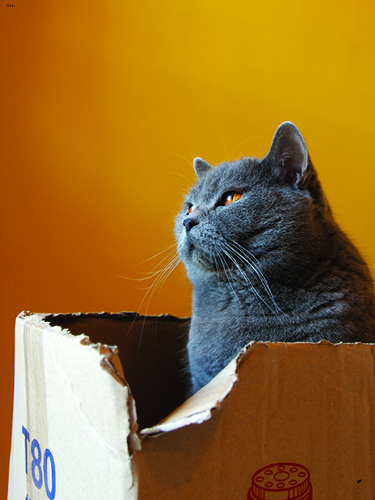

	 ground truth mask image: 0


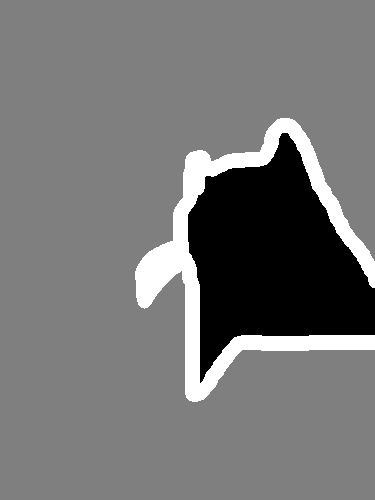

	 predicted mask image: 0


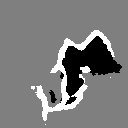

----- test image: 1
	 imput image: 1


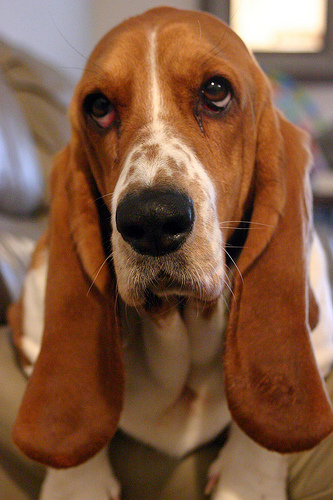

	 ground truth mask image: 1


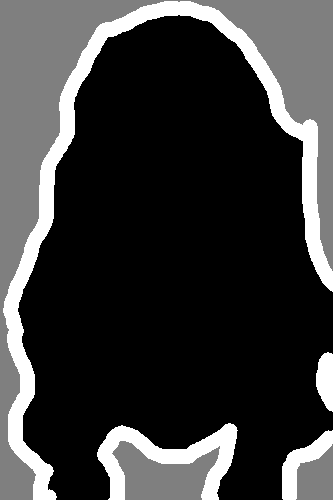

	 predicted mask image: 1


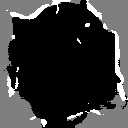

----- test image: 2
	 imput image: 2


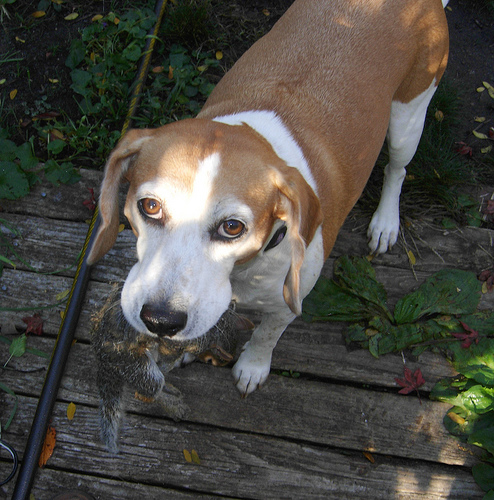

	 ground truth mask image: 2


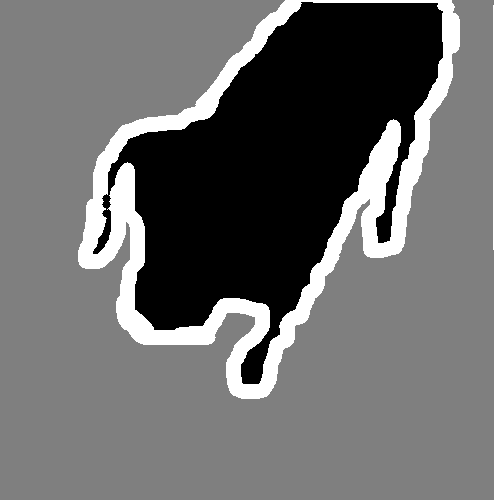

	 predicted mask image: 2


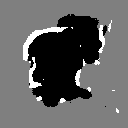

In [22]:
# Display results for first 3 test images
nimg = 3
for i in range(nimg):
  print(f"----- test image: {i}")
  print(f"\t imput image: {i}")
  # Display input image
  display(Image(filename=test_input_img_paths[i]))

  print(f"\t ground truth mask image: {i}")
  # Display ground-truth target mask
  img = ImageOps.autocontrast(load_img(test_target_img_paths[i]))
  display(img)


  print(f"\t predicted mask image: {i}")
  # Display mask predicted by our model
  img = ImageOps.autocontrast(tf.keras.utils.array_to_img(th_pred[i]))
  # Note that the model only sees inputs at 128x128.
  display(img)


# **Computing the performance: intersection over union (IoU) coefficient**
* ## $\text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$
> * ## *Area of Overlap*: This is the common area shared by the predicted segmentation (or bounding box) and the ground truth.
> * ## *Area of Union*: This is the total area covered by both the predicted segmentation and the ground truth.
* ## IoU is in [0,1], the higher the better the model performace

In [23]:
def compute_iou(y_true, y_pred):
    # Flatten arrays to compute metrics
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Compute Intersection over Union (IoU)
    intersection = np.sum(np.logical_and(y_true_flat, y_pred_flat))
    union = np.sum(np.logical_or(y_true_flat, y_pred_flat))
    iou = intersection / union if union != 0 else 0

    return iou

# Extract ground truth (y_true) from the test dataset
y_true = []
for _, target_img in test_dataset:
    y_true.extend(target_img.numpy())  # Append ground truth masks as numpy

# Compute IoU for all images
ious = []
for i in range(len(th_pred)):
    iou = compute_iou(y_true[i].squeeze(), th_pred[i].squeeze())  # Remove extra channel if present
    ious.append(iou)

# Print average IoU across test dataset
average_iou = np.mean(ious)
print("Average IoU:", average_iou)

Average IoU: 0.7987135376982021


# **Conclusions**
## The model can improve its ability in predicting reliable segmented trimaps, and it is expected since we both reduced much the model size, and did not tune it
## Moreover we did not reach the plateau of training, so increasing the number of epochs/calibrating learning rate and batch size would help as well

# **Exercise**
* ## By keeping around the same number of parameters, evaluate 1) The dropout helps? 2) The concatenate layers helps? 3) The batch normalization helps?

Original: 0.8143205062450193

No dropdout: 0.8351700921030387

No concatenate: 0.8029323976945626

No batch normalization: 0.7987135376982021